# Introduction

The purpose of this document is to explore the methods of simulation of square-root processes as seen in Anderson et. al (2010)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# The CIR Process

In this section we implement methods for simulating the CIR Process
$$dx(t) = \kappa(\theta - x(t))\,dt + \epsilon\sqrt{x(t)}\,dW_t$$
where $x(0) = x_0$.

In [3]:
#Setting the paramaters of the process
kappa = 1
theta = 0.05
epsilon = 0.1
x_0 = 0.05

delta = 0.5
time_steps = 100
simulations = 10

d = 4*kappa*theta/epsilon**2
if d < 2:
    print("Warning: Feller condition not satisfied!")
    

#Now that our parameters are set, let's use exact simulation to build paths of x
x = np.zeros((time_steps+1,simulations))
x[0,:] = x_0

## Exact Simulation

To perform exact simulation, we do the following process:
1. Draw a Poisson random variable $N$ with mean $\frac{1}{2}x(t)n(t,t+\Delta)$
2. Given, $N$, draw a $\chi_v^2$ random variable with $d+2N$ degrees of freedom.
3. Put $x(t+\Delta) = \chi_v^2*\exp(-\kappa\Delta)/n(t,t+\Delta)$

There is no bias, but it's not very robust and will become slow for a large amount of simulations and time steps. You have been warned.

In [78]:
def n(t,T, kappa, epsilon):
    return 4*kappa*np.exp(-1*kappa*(T-t))/(epsilon**2*(1 - np.exp(-1*kappa*(T-t))))

In [61]:
for i in range(time_steps):
    for j in range(simulations):
        n_comp = n((i)*delta,(i+1)*delta,kappa,epsilon)
        mean = 0.5*x[i,j]*n_comp
        N = np.random.poisson(mean)
        chisq = np.random.chisquare(d+2*N)
        x[i+1,j] = chisq*np.exp(-1*kappa*delta)/n_comp

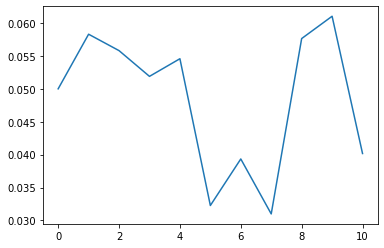

In [62]:
plt.plot(x[:,1])

## Euler Scheme

Now I'm going to follow the scheme $\hat{x}(t + \Delta) = \hat{x}(t) + \kappa(\theta - \hat{x}(t)^+)\Delta + \epsilon\sqrt{\hat{x}(t)^+}Z\sqrt{\Delta}$. This simulation is not exact, but quicker since the simulation can be done with iid standard normals.

In [76]:
for i in range(time_steps):
    Z = np.random.normal(0,1,simulations)
    #print(Z)
    x_i = np.copy(x[i,:])
    #print(x)
    x_i[np.where(x_i < 0)] = 0
    #print(x_i)
    
    x[i+1,:] = x_i + kappa*(theta - x_i)*delta + epsilon*np.sqrt(x_i)*Z*np.sqrt(delta)

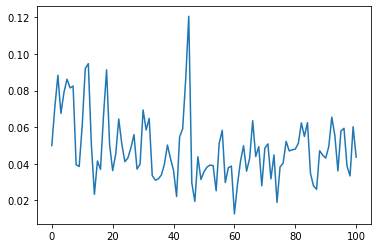

In [77]:
plt.plot(x[:,0])

## Implicit Milstein Scheme

The implicit Milstein scheme is given by
$$ \hat{x}(t+\Delta) = (1 + \kappa\Delta)^{-1}\big(\hat{x}(t) + \kappa\theta\Delta + \epsilon\sqrt{\hat{x}(T)\Delta}Z + \frac{1}{4}\epsilon^2\Delta(Z^2 - 1)\big)$$
This scheme is guaranteed to have strictly positive paths if $4\kappa\theta > \epsilon^2$. For a proof, see https://www.overleaf.com/read/tbsmxpxdykhh. Like the Euler scheme this can generated with iid standard normals. Note there is no guarantee that this scheme will exhibit second-order weak convergence.

In [16]:
#Setting the paramaters of the process
kappa = 1
theta = 0.05
epsilon = 0.1
x_0 = 0.05

delta = 0.5
time_steps = 100
simulations = 10

d = 4*kappa*theta/epsilon**2
if d < 2:
    print("Warning: Feller condition not satisfied!")
    

#Now that our parameters are set, let's build the paths of the process
x = np.zeros((time_steps+1,simulations))
x[0,:] = x_0

In [17]:
for i in range(time_steps):
    Z = np.random.normal(0,1,simulations)
    x_i = np.copy(x[i,:])
    denominator = 1 + kappa*delta
    x[i+1] = (1/denominator)*(x_i + kappa*theta*delta + epsilon*np.sqrt(x_i*delta)*Z + 0.25*(epsilon**2)*delta*(Z*Z - 1))

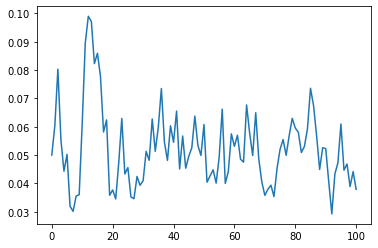

In [18]:
plt.plot(x[:,0])

## Summary

The above survey of different numerical methods can be summarized in a single one-size-fits-all function:

In [42]:
def n(t,T, kappa, epsilon):
    return 4*kappa*np.exp(-1*kappa*(T-t))/(epsilon**2*(1 - np.exp(-1*kappa*(T-t))))

def CIR(kappa, theta, epsilon, x_0, delta, time_steps, simulations, method):
    #Generate "simulations" number of simulations of a CIR process with the given parameters
    #using the method "method"

    d = 4*kappa*theta/epsilon**2
    if d < 2:
        print("Warning: Feller condition not satisfied!")

    #The matrix x contains the simulated paths
    x = np.zeros((time_steps+1,simulations))
    x[0,:] = x_0
    
    for i in range(time_steps):
        
        if method == "implicit_milstein":
            Z = np.random.normal(0,1,simulations)
            x_i = np.copy(x[i,:])
            
            denominator = 1 + kappa*delta
            x[i+1,:] = (1/denominator)*(x_i + kappa*theta*delta + epsilon*np.sqrt(x_i*delta)*Z + 0.25*(epsilon**2)*delta*(Z*Z - 1))
        elif method == "euler":
            Z = np.random.normal(0,1,simulations)
            x_i = np.copy(x[i,:])
            
            x_i[np.where(x_i < 0)] = 0
            x[i+1,:] = x_i + kappa*(theta - x_i)*delta + epsilon*np.sqrt(x_i)*Z*np.sqrt(delta)
        elif method == "exact":
            for j in range(simulations):
                n_comp = n((i)*delta,(i+1)*delta,kappa,epsilon)
                mean = 0.5*x[i,j]*n_comp
                N = np.random.poisson(mean)
                chisq = np.random.chisquare(d+2*N)
                x[i+1,j] = chisq*np.exp(-1*kappa*delta)/n_comp
        
    #When the for loop terminates, we'll have our simulated data set which we can return to be used for other things
    return x

Here is a sample use case of the above function

In [40]:
kappa = 1
theta = 0.05
epsilon = 0.1
x_0 = 0.05

delta = 0.5
time_steps = 100
simulations = 3

method = "exact"

x = CIR(kappa, theta, epsilon, x_0, delta, time_steps, simulations, method)

Text(0, 0.5, 'Value of x')

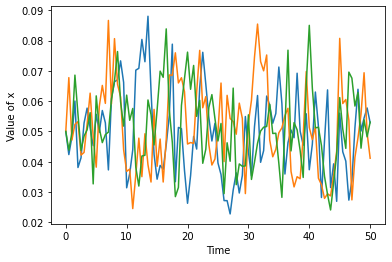

In [41]:
t = [delta*i for i in range(time_steps+1)]
for i in range(np.shape(x)[1]):
    plt.plot(t,x[:,i])
plt.xlabel("Time")
plt.ylabel("Value of x")

# Heston Model Simulation

It is useful to know how to simulate square-root processes because they are used to model stochastic volatility. In this section we consider the Heston Model given by
\begin{align}
    dY(t) &= Y(t)\sqrt{x(t)}\big(\rho\,dW(t) + \sqrt{1 - \rho^2}\,dB(t)\big) \\
    dx(t) &= \kappa(\theta - x(t))\,dt + \epsilon\sqrt{x(t)}dW(t)
\end{align}
where $W$ and $B$ are independent Brownian motions.

In [160]:
#Setting the paramaters of the process
kappa = 1
theta = 0.05/365
epsilon = 0.05/365
x_0 = 0.05

lny_0 = np.log(100)
rho = 0.1

d = 4*kappa*theta/epsilon**2
if d < 2:
    print("Warning: Feller condition not satisfied!")

delta = 0.05
time_steps = 1000
simulations = 10

#Now that our parameters are set, let's use exact simulation to build paths of x
x = np.zeros((time_steps+1,simulations))
lny = np.zeros((time_steps+1,simulations))
x[0,:] = x_0
lny[0,:] = lny_0

## Simplified Broadie-Kaya

Increments in the CIR process are done with exact simulation while numerical integration is handled with a trapezoid method.

In [161]:
for i in range(0,time_steps):
    for j in range(simulations):
        n_comp = n(i*delta,(i+1)*delta,kappa,epsilon)
        mean = 0.5*x[i,j]*n_comp
        N = np.random.poisson(mean)
        chisq = np.random.chisquare(d+2*N)
        x[i+1,j] = chisq*np.exp(-1*kappa*delta)/n_comp
        
        #At this point, we've updated x to time i+1 on the jth simulation path...
        #But now we want to simulate I. For now, let's keep things simple and just use a central discretization approximation
        
        I = 0.5*delta*(x[i,j] + x[i+1,j])
        
        #Finally, with x and I updated, we are ready to update lny
        mean = lny[i,j] + (rho/epsilon)*(x[i+1,j] - x[i,j] - kappa*theta*delta) + (kappa*rho/epsilon - 0.5)*I 
        std = np.sqrt((1 - rho**2)*I)
        lny[i+1,j] = np.random.normal(mean, std)

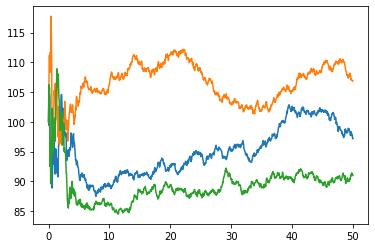

In [162]:
y = np.exp(lny)
x_axis = [i*delta for i in range(time_steps+1)]
for i in range(3):
    plt.plot(x_axis, y[:,i])

# CIR-based Volatility in the Kyle-Back Model

For more details we refer the reader to https://arxiv.org/abs/2204.11069. If we let
\begin{align}
V_t &= x_0 + \int_0^t \kappa(\theta - V_s)\,ds + \int_0^t \eta^2\sqrt{V_s}\,dW_s
\end{align}
Then, $\sigma_t = \underline{\sigma} + \min(\sqrt{V_t},\overline{\sigma})$ is a volatility process that satisfies Assumption 2.1 (3) of the above paper and hence with a valid choice of the market maker's prior will yield an equilibrium. Since we know how to simulate $V_t$ and $\sigma_t$ is just a modified form of $V_t$, we can simulate the noise trader process
\begin{align}
    Z_t &= \int_0^t \sigma_s\big(\sqrt{1 - \rho^2}\,dB_s + \rho\,dW_s\big)
\end{align}
using techniques previously explored in this notebook. The integration on Z is admittedly handled in quite a crude way. (TODO: How can I handle the integration of Z in a robust manner?)

In [101]:
##############################
#Setting the paramaters of V_t
kappa = 1
theta = 0.05
epsilon = 0.1
x_0 = 0.05

delta = 0.25
time_steps = 200
simulations = 10

d = 4*kappa*theta/epsilon**2
if d < 2:
    print("Warning: Feller condition not satisfied!")
    
################################################
#Setting the upper and lower limit of volatility
sigma_low = 0.01
sigma_high = np.sqrt(0.09)

#########################################################
#Setting the correlation of noise traders with volatility
rho = 0.5

#Now that our parameters are set, let's build the paths of the process
V = np.zeros((time_steps+1,simulations))
V[0,:] = x_0

sigma = np.zeros((time_steps+1,simulations))
sigma[0,:] = sigma_low + np.minimum(np.sqrt(x_0),sigma_high)

Z = np.zeros((time_steps+1,simulations))

Here, I use implicit Milstein to perform the simulation on V and approximate the integration on Z with a trapezoid.

In [102]:
for i in range(time_steps):
    #First simulate the next time step values of V_t
    W = np.random.normal(0,1,simulations)
    B = np.random.normal(0,1,simulations)
    V_i = np.copy(V[i,:])
            
    denominator = 1 + kappa*delta
    V[i+1,:] = (1/denominator)*(V_i + kappa*theta*delta + epsilon*np.sqrt(V_i*delta)*W + 0.25*(epsilon**2)*delta*(W*W - 1))
    
    #Now compute sigma at the next time step
    sigma[i+1,:] = sigma_low + np.minimum(np.sqrt(V[i+1,:]),sigma_high)
    
    #Now compute Z_t at the next time step
    Z[i+1,:] = Z[i,:] + 0.5*(sigma[i,:] + sigma[i+1,:])*(np.sqrt(1-rho**2)*np.sqrt(delta)*B + rho*np.sqrt(delta)*W)

Here's a visual representation of one of the simulation paths:

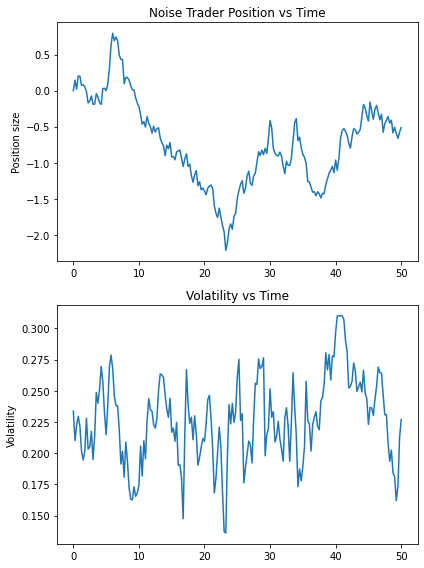

In [103]:
t = [delta*i for i in range(time_steps+1)]
fig,ax = plt.subplots(2)

ax[0].plot(t,Z[:,0])
ax[1].plot(t,sigma[:,0])

ax[0].set_title("Noise Trader Position vs Time")
ax[1].set_title("Volatility vs Time")

ax[0].set_ylabel("Position size")
ax[1].set_ylabel("Volatility")

fig.set_size_inches(6,2*4)
fig.tight_layout()